In [44]:
%matplotlib inline
#DSTI Python Labs Project
#Author: Sergey Lukyanchikov

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

path=r'C:\Users\slukyanc\Desktop\Machine Learning with Python Labs'

Data = pd.read_csv (path+'\stroke_data.csv')

In [46]:
#EDA start

#Percentages of missing values per variable:

print(Data.isna().astype(int).mean()*100) #we can harmlessly suppress records with missing values

print("\n")

#Deleting from the source dataset records with missing values:

Data = Data.dropna(subset=['bmi'])

#Checking that no variable has zero variance or a degenerate distribution:

print(Data.describe()) #none of the variables has zero variance, all of the variables have a non-degenerate distribution

print("\n")

#Checking than no pair of distinct variables correlates above 0.5 (full True means that the check has passed OK):

print(np.array((abs(Data.corr())>0.5).astype(int))==np.identity(len(Data.corr()))) #we can proceed without dropping variables due to correlation

#EDA end

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


                 id          age  hypertension  heart_disease  \
count   4909.000000  4909.000000   4909.000000    4909.000000   
mean   37064.313506    42.865374      0.091872       0.049501   
std    20995.098457    22.555115      0.288875       0.216934   
min       77.000000     0.080000      0.000000       0.000000   
25%    18605.000000    25.000000      0.000000       0.000000   
50%    37608.000000    44.000000      0.000000       0.000000   
75%    55220.000000    60.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi

In [47]:
def run(Data, droplist, balancing, training, preddraw, costoferror, costofchecking, predfrac, testdraws, folds, bagfrac, weights, weightsaccval, weightsacctst, path):

    #Initializing varibles for graphics:
    
    f011=None
    f012=None
    f013=None
    f014=None
    f021=None
    f022=None
    f023=None
    f031=None
    f032=None
    f033=None
    f034=None
    
    #Building a balanced dataset

    Targets=Data.loc[Data['stroke']==1]
    NonTargets=Data.loc[Data['stroke']==0]
    NonTargets=NonTargets.sample(len(Targets)*balancing)
    Dataset=Targets.append(NonTargets)
  
    #Fitting categorical variable encoders:

    gender=pd.DataFrame(Dataset['gender'])
    ohe_gender=OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_gender.fit(gender)
    ever_married=pd.DataFrame(Dataset['ever_married'])
    ohe_ever_married=OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_ever_married.fit(ever_married)
    work_type=pd.DataFrame(Dataset['work_type'])
    ohe_work_type=OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_work_type.fit(work_type)
    Residence_type=pd.DataFrame(Dataset['Residence_type'])
    ohe_Residence_type=OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_Residence_type.fit(Residence_type)
    smoking_status=pd.DataFrame(Dataset['smoking_status'])
    ohe_smoking_status=OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_smoking_status.fit(smoking_status)

    if training>=1:
        ModelMart=[]
        if 'ModelDict' not in locals().keys():
            ModelDict={}

    divisorpred=preddraw
    
    #Converting (encoding) string values of categorical variables to numeric values:
    
    gender_enc=pd.DataFrame(ohe_gender.transform(gender), columns=["{}{}".format('gender_',i) for i in np.array(ohe_gender.categories_).tolist()[0]])
    ever_married_enc=pd.DataFrame(ohe_ever_married.transform(ever_married), columns=["{}{}".format('ever_married_',i) for i in np.array(ohe_ever_married.categories_).tolist()[0]])
    work_type_enc=pd.DataFrame(ohe_work_type.transform(work_type), columns=["{}{}".format('work_type_',i) for i in np.array(ohe_work_type.categories_).tolist()[0]])
    Residence_type_enc=pd.DataFrame(ohe_Residence_type.transform(Residence_type), columns=["{}{}".format('Residence_type_',i) for i in np.array(ohe_Residence_type.categories_).tolist()[0]])
    smoking_status_enc=pd.DataFrame(ohe_smoking_status.transform(smoking_status), columns=["{}{}".format('smoking_status_',i) for i in np.array(ohe_smoking_status.categories_).tolist()[0]])
    
    DatasetA=pd.concat([Dataset.reset_index(drop=True), gender_enc, ever_married_enc, work_type_enc, Residence_type_enc, smoking_status_enc], axis=1)
    
    if predfrac>0:
        #Randomized splitting of the balanced dataset into a training and prediction datasets:
        PatlistA=pd.DataFrame(DatasetA['id'].unique())
        PatlistB=PatlistA.sample(frac=predfrac)
        PatlistC=PatlistA[~PatlistA[0].isin(PatlistB[0])]
        DatasetB=DatasetA[DatasetA['id'].isin(PatlistB[0])]
        DatasetC=DatasetA[DatasetA['id'].isin(PatlistC[0])]
    
    #Randomized extraction of a patientset for experiment 1/3
    
    Patientset01=DatasetB.sample(frac=bagfrac)
    X01=Patientset01.drop(droplist, axis=1)
    Y01=Patientset01['stroke']
    Y01=Y01.astype('int')
    
    #If testdraws parameter (see above) is set to 1, perform an additional split for experiment-level model training and accuracy testing
    
    if testdraws==0:
        X01_train=X01
        Y01_train=Y01
    else:
        X01_train, X01_test, Y01_train, Y01_test = train_test_split(X01, Y01, test_size=0.2, shuffle=False)
    
    #Train a set of models on the training portion of the patientset:
    
    knn01 = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(1, min(25,Y01_train[Y01_train==1].count()))}, cv=folds, iid=...).fit(X01_train, Y01_train).best_estimator_
    rf01 = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200]}, cv=folds, iid=...).fit(X01_train, Y01_train).best_estimator_
    logit01 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=10000), {'C': [0.1, 0.5, 1, 50, 100, 500, 1000, 5000, 10000]}, cv=folds, iid=...).fit(X01_train, Y01_train).best_estimator_
    
    #Do a validation (apply models to the training portion of the patientset)
    
    Y01HATVAL_knn01 = knn01.predict(X01_train)
    Y01HATVAL_rf01 = rf01.predict(X01_train)
    Y01HATVAL_logit01 = logit01.predict(X01_train)
    
    #If testdraws is set to 1, do an accuracy test (apply models to the testing portion of the patientset)
    
    if testdraws==1:
        Y01HATTST_knn01 = knn01.predict(X01_test)
        Y01HATTST_rf01 = rf01.predict(X01_test)
        Y01HATTST_logit01 = logit01.predict(X01_test)
    
    #Randomized extraction of a patientset for experiment 2/3
    
    Patientset02=DatasetB.sample(frac=bagfrac)
    X02=Patientset02.drop(droplist, axis=1)
    Y02=Patientset02['stroke']
    Y02=Y02.astype('int')
    
    #If testdraws parameter (see above) is set to 1, perform an additional split for experiment-level model training and accuracy testing
    
    if testdraws==0:
        X02_train=X02
        Y02_train=Y02
    else:
        X02_train, X02_test, Y02_train, Y02_test = train_test_split(X02, Y02, test_size=0.2, shuffle=False)
    
    #Train a set of models on the training portion of the patientset:
    
    knn02 = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(1, min(25,Y02_train[Y02_train==1].count()))}, cv=folds, iid=...).fit(X02_train, Y02_train).best_estimator_
    rf02 = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200]}, cv=folds, iid=...).fit(X02_train, Y02_train).best_estimator_
    logit02 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=10000), {'C': [0.1, 0.5, 1, 50, 100, 500, 1000, 5000, 10000]}, cv=folds, iid=...).fit(X02_train, Y02_train).best_estimator_
    
    #Do a validation (apply models to the training portion of the patientset)
    
    Y02HATVAL_knn02 = knn02.predict(X02_train)
    Y02HATVAL_rf02 = rf02.predict(X02_train)
    Y02HATVAL_logit02 = logit02.predict(X02_train)
    
    #If testdraws is set to 1, do an accuracy test (apply models to the testing portion of the patientset)
    
    if testdraws==1:
        Y02HATTST_knn02 = knn02.predict(X02_test)
        Y02HATTST_rf02 = rf02.predict(X02_test)
        Y02HATTST_logit02 = logit02.predict(X02_test)
    
    #Randomized extraction of a patientset for experiment 3/3
    
    Patientset03=DatasetB.sample(frac=bagfrac)
    X03=Patientset03.drop(droplist, axis=1)
    Y03=Patientset03['stroke']
    Y03=Y03.astype('int')
    
    #If testdraws parameter (see above) is set to 1, perform an additional split for experiment-level model training and accuracy testing
    
    if testdraws==0:
        X03_train=X03
        Y03_train=Y03
    else:
        X03_train, X03_test, Y03_train, Y03_test = train_test_split(X03, Y03, test_size=0.2, shuffle=False)
    
    #Train a set of models on the training portion of the patientset:
    
    knn03 = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(1, min(25,Y03_train[Y03_train==1].count()))}, cv=folds, iid=...).fit(X03_train, Y03_train).best_estimator_
    rf03 = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200]}, cv=folds, iid=...).fit(X03_train, Y03_train).best_estimator_
    logit03 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=10000), {'C': [0.1, 0.5, 1, 50, 100, 500, 1000, 5000, 10000]}, cv=folds, iid=...).fit(X03_train, Y03_train).best_estimator_
    
    #Do a validation (apply models to the training portion of the patientset)
    
    Y03HATVAL_knn03 = knn03.predict(X03_train)
    Y03HATVAL_rf03 = rf03.predict(X03_train)
    Y03HATVAL_logit03 = logit03.predict(X03_train)
    
    #If testdraws is set to 1, do an accuracy test (apply models to the testing portion of the patientset)
    
    if testdraws==1:
        Y03HATTST_knn03 = knn03.predict(X03_test)
        Y03HATTST_rf03 = rf03.predict(X03_test)
        Y03HATTST_logit03 = logit03.predict(X03_test)
    
    #Randomized extraction of a patientset for the ensemble experiment
    
    Patientset00=DatasetB.sample(frac=bagfrac)
        
    X00=Patientset00.drop(droplist, axis=1)
    Y00=Patientset00['stroke']
    Y00=Y00.astype('int')
        
    if testdraws==0:
        X00_train=X00
        Y00_train=Y00
    else:    
        X00_train, X00_test, Y00_train, Y00_test = train_test_split(X00, Y00, test_size=0.2*testdraws, shuffle=False)
    
    #Training the voting ensemble
    
    all = VotingClassifier([('knn01', knn01), ('rf01', rf01), ('logit01', logit01), ('knn02', knn02), ('rf02', rf02), ('logit02', logit02), ('knn03', knn03), ('rf03', rf03), ('logit03', logit03)], voting='soft', weights=weights).fit(X00_train, Y00_train)
    
    #Validation of the voting ensemble
    
    Y00HATVAL_all=all._predict_proba(X00_train)[:,1]
    Y00HATVAL_all_bin=all.predict(X00_train)
    
    #Building validation-related metrics and graphs
        
    MonitorVAL01=pd.DataFrame(columns=['ID','ACCURACY','PARAMS'])
    
    for k in all.get_params(deep=True)['estimators']:
        estimator=pd.DataFrame([k[0], accuracy_score(eval('Y'+k[0][-2:]+'_train'), eval('Y'+k[0][-2:]+'HATVAL_'+k[0])), all.get_params(deep=True)[k[0]]], index=['ID','ACCURACY','PARAMS']).T
        MonitorVAL01=MonitorVAL01.append(estimator)
        
    MonitorVAL02=pd.DataFrame(columns=['ID']+(X00.columns+'_pvalue').tolist())
    
    for k in all.get_params(deep=True)['estimators']:
        estimator=pd.DataFrame([k[0]]+f_classif(eval('X'+k[0][-2:]+'_train'), eval('Y'+k[0][-2:]+'HATVAL_'+k[0]))[1].tolist(), index=MonitorVAL02.columns.tolist()).T
        MonitorVAL02=MonitorVAL02.append(estimator)
    
    if weightsaccval==1:
        #weights=np.array(MonitorVAL01['ACCURACY']/MonitorVAL01['ACCURACY'].sum())
        weights=np.array((MonitorVAL01['ACCURACY']-MonitorVAL01['ACCURACY'].min())/(MonitorVAL01['ACCURACY']-MonitorVAL01['ACCURACY'].min()).sum())
        all = VotingClassifier([('knn01', knn01), ('rf01', rf01), ('logit01', logit01), ('knn02', knn02), ('rf02', rf02), ('logit02', logit02), ('knn03', knn03), ('rf03', rf03), ('logit03', logit03)], voting='soft', weights=weights).fit(X00_train, Y00_train)
    
    #Building testing-related metrics and graphs (part 1: experiment-level metrics)
        
    if testdraws==1:
        MonitorTST01=pd.DataFrame(columns=['ID','ACCURACY','PARAMS'])
    
        for k in all.get_params(deep=True)['estimators']:
            estimator=pd.DataFrame([k[0], accuracy_score(eval('Y'+k[0][-2:]+'_test'), eval('Y'+k[0][-2:]+'HATTST_'+k[0])), all.get_params(deep=True)[k[0]]], index=['ID','ACCURACY','PARAMS']).T
            MonitorTST01=MonitorTST01.append(estimator)
            
        MonitorTST02=pd.DataFrame(columns=['ID']+(X00.columns+'_pvalue').tolist())
    
        for k in all.get_params(deep=True)['estimators']:
            estimator=pd.DataFrame([k[0]]+f_classif(eval('X'+k[0][-2:]+'_test'), eval('Y'+k[0][-2:]+'HATTST_'+k[0]))[1].tolist(), index=MonitorTST02.columns.tolist()).T
            MonitorTST02=MonitorTST02.append(estimator)
            
        if weightsacctst==1:
            #weights=np.array(MonitorTST01['ACCURACY']/MonitorTST01['ACCURACY'].sum())
            weights=np.array((MonitorTST01['ACCURACY']-MonitorTST01['ACCURACY'].min())/(MonitorTST01['ACCURACY']-MonitorTST01['ACCURACY'].min()).sum())
            all = VotingClassifier([('knn01', knn01), ('rf01', rf01), ('logit01', logit01), ('knn02', knn02), ('rf02', rf02), ('logit02', logit02), ('knn03', knn03), ('rf03', rf03), ('logit03', logit03)], voting='soft', weights=weights).fit(X00_train, Y00_train)
    
    estimator=pd.DataFrame(['all', accuracy_score(Y00_train, Y00HATVAL_all_bin), [str(key)+': '+str(all.get_params(deep=False).get(key)) for key in ['flatten_transform', 'n_jobs', 'voting', 'weights']]], index=['ID','ACCURACY','PARAMS']).T
    MonitorVAL01=MonitorVAL01.append(estimator)
    MonitorVAL01=MonitorVAL01.reset_index(drop=True)
    
    estimator=pd.DataFrame(['all']+f_classif(X00_train, Y00HATVAL_all_bin)[1].tolist(), index=MonitorVAL02.columns.tolist()).T
    MonitorVAL02=MonitorVAL02.append(estimator)
    MonitorVAL02=MonitorVAL02.reset_index(drop=True)
    
    MonitorVAL=pd.merge(MonitorVAL01, MonitorVAL02, on=['ID'])
    
    Coefficients=pd.DataFrame(columns=['ID', 'INTERCEPT']+(X00.columns+'_coeff').tolist())
    
    for k in ['logit01', 'logit02', 'logit03']:
        estimator=pd.DataFrame([k]+eval(k+'.intercept_').tolist()+eval(k+'.coef_').tolist()[0], index=Coefficients.columns.tolist()).T
        Coefficients=Coefficients.append(estimator)
    
    estimator=pd.DataFrame(['averaged']+np.array(Coefficients.agg(['mean']))[0].tolist(), index=Coefficients.columns.tolist()).T
    Coefficients=Coefficients.append(estimator)
    Coefficients=Coefficients.reset_index(drop=True)
    
    fpr_knn01, tpr_knn01, _ = roc_curve(Y01_train, Y01HATVAL_knn01, pos_label=1)
    fpr_rf01, tpr_rf01, _ = roc_curve(Y01_train, Y01HATVAL_rf01)
    fpr_logit01, tpr_logit01, _ = roc_curve(Y01_train, Y01HATVAL_logit01)
    fpr_knn02, tpr_knn02, _ = roc_curve(Y02_train, Y02HATVAL_knn02)
    fpr_rf02, tpr_rf02, _ = roc_curve(Y02_train, Y02HATVAL_rf02)
    fpr_logit02, tpr_logit02, _ = roc_curve(Y02_train, Y02HATVAL_logit02)
    fpr_knn03, tpr_knn03, _ = roc_curve(Y03_train, Y03HATVAL_knn03)
    fpr_rf03, tpr_rf03, _ = roc_curve(Y03_train, Y03HATVAL_rf03)
    fpr_logit03, tpr_logit03, _ = roc_curve(Y03_train, Y03HATVAL_logit03)
    fpr_all, tpr_all, _ = roc_curve(Y00_train, Y00HATVAL_all)
    
    f=plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_knn01, tpr_knn01, label='KNN01')
    plt.plot(fpr_rf01, tpr_rf01, label='RF01')
    plt.plot(fpr_logit01, tpr_logit01, label='LOGIT01')
    plt.plot(fpr_knn02, tpr_knn02, label='KNN02')
    plt.plot(fpr_rf02, tpr_rf02, label='RF02')
    plt.plot(fpr_logit02, tpr_logit02, label='LOGIT02')
    plt.plot(fpr_knn03, tpr_knn03, label='KNN03')
    plt.plot(fpr_rf03, tpr_rf03, label='RF03')
    plt.plot(fpr_logit03, tpr_logit03, label='LOGIT03')
    plt.plot(fpr_all, tpr_all, label='KNN+RF+LOGIT')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves: VAL')
    plt.legend(loc='best')
    f.savefig(path+'\DSTI011.png')
    f011=f
    plt.close(f)
    
    f=plt.figure(figsize=(20, 10))
    plt.barh(MonitorVAL['ID'], MonitorVAL['ACCURACY'])
    plt.xlabel('Accuracy')
    plt.title('Model Accuracies: VAL')
    f.savefig(path+'\DSTI012.png')
    f012=f
    plt.close(f)
    
    f=plt.figure(figsize=(20, 100))
    plt.barh(MonitorVAL.columns[3:], MonitorVAL.iloc[-1,3:])
    plt.xlabel('p-Value')
    plt.title('Ensemble Variable p-Values: VAL')
    f.savefig(path+'\DSTI013.png')
    f013=f
    plt.close(f)
    
    f=plt.figure(figsize=(20, 100))
    plt.barh(Coefficients.columns[1:], Coefficients.iloc[-1,1:])
    plt.xlabel('Averaged Coefficient')
    plt.title('Averaged Variable Coefficients: VAL')
    f.savefig(path+'\DSTI014.png')
    f014=f
    plt.close(f)
    
    ModelMart.append(all)
    
    if testdraws==1:
        #If testdraws is set to 1, do an accuracy test using the voting ensemble
        
        Y00HATTST_all=all._predict_proba(X00_test)[:,1]
        Y00HATTST_all_bin=all.predict(X00_test)
        
        #Building testing-related metrics and graphs (part 2: ensemble-level metrics)
        
        estimator=pd.DataFrame(['all', accuracy_score(Y00_test, Y00HATTST_all_bin), [str(key)+': '+str(all.get_params(deep=False).get(key)) for key in ['flatten_transform', 'n_jobs', 'voting', 'weights']]], index=['ID','ACCURACY','PARAMS']).T
        MonitorTST01=MonitorTST01.append(estimator)
        MonitorTST01=MonitorTST01.reset_index(drop=True)
    
        estimator=pd.DataFrame(['all']+f_classif(X00_test, Y00HATTST_all_bin)[1].tolist(), index=MonitorTST02.columns.tolist()).T
        MonitorTST02=MonitorTST02.append(estimator)
        MonitorTST02=MonitorTST02.reset_index(drop=True)
    
        MonitorTST=pd.merge(MonitorTST01, MonitorTST02, on=['ID'])
    
        fpr_knn01, tpr_knn01, _ = roc_curve(Y01_test, Y01HATTST_knn01, pos_label=1)
        fpr_rf01, tpr_rf01, _ = roc_curve(Y01_test, Y01HATTST_rf01)
        fpr_logit01, tpr_logit01, _ = roc_curve(Y01_test, Y01HATTST_logit01)
        fpr_knn02, tpr_knn02, _ = roc_curve(Y02_test, Y02HATTST_knn02)
        fpr_rf02, tpr_rf02, _ = roc_curve(Y02_test, Y02HATTST_rf02)
        fpr_logit02, tpr_logit02, _ = roc_curve(Y02_test, Y02HATTST_logit02)
        fpr_knn03, tpr_knn03, _ = roc_curve(Y03_test, Y03HATTST_knn03)
        fpr_rf03, tpr_rf03, _ = roc_curve(Y03_test, Y03HATTST_rf03)
        fpr_logit03, tpr_logit03, _ = roc_curve(Y03_test, Y03HATTST_logit03)
        fpr_all, tpr_all, _ = roc_curve(Y00_test, Y00HATTST_all)
    
        f=plt.figure()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_knn01, tpr_knn01, label='KNN01')
        plt.plot(fpr_rf01, tpr_rf01, label='RF01')
        plt.plot(fpr_logit01, tpr_logit01, label='LOGIT01')
        plt.plot(fpr_knn02, tpr_knn02, label='KNN02')
        plt.plot(fpr_rf02, tpr_rf02, label='RF02')
        plt.plot(fpr_logit02, tpr_logit02, label='LOGIT02')
        plt.plot(fpr_knn03, tpr_knn03, label='KNN03')
        plt.plot(fpr_rf03, tpr_rf03, label='RF03')
        plt.plot(fpr_logit03, tpr_logit03, label='LOGIT03')
        plt.plot(fpr_all, tpr_all, label='KNN+RF+LOGIT')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curves: TST')
        plt.legend(loc='best')
        f.savefig(path+'\DSTI021.png')
        f021=f
        plt.close(f)
    
        f=plt.figure(figsize=(20, 10))
        plt.barh(MonitorTST['ID'], MonitorTST['ACCURACY'])
        plt.xlabel('Accuracy')
        plt.title('Model Accuracies: TST')
        f.savefig(path+'\DSTI022.png')
        f022=f
        plt.close(f)
        
        f=plt.figure(figsize=(20, 100))
        plt.barh(MonitorTST.columns[3:], MonitorTST.iloc[-1,3:])
        plt.xlabel('p-Value')
        plt.title('Ensemble Variable p-Values: TST')
        f.savefig(path+'\DSTI023.png')
        f023=f
        plt.close(f)
    
    if preddraw>=1:
    
        #PREDICTION (ON A BATCH OF PATIENTS)
    
        #Building a patientset for prediction
    
        Patientset=DatasetC
    
        X=Patientset.drop(droplist, axis=1)
        Y=Patientset['stroke']
        Y=Y.astype('int')
    
        #Predicting using the voting ensemble
            
        if training==0:
            all=ModelDict[''.join('stroke')][(preddraw-1)%len(ModelDict[''.join('stroke')])]
    
        YHAT=all._predict_proba(X)[:,1]
        YHAT_bin=all.predict(X)
    
        #Building prediction-related metrics and graphs
    
        fpr_pred, tpr_pred, _ = roc_curve(Y, YHAT, pos_label=1)
    
        f=plt.figure()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_pred, tpr_pred, label='KNN+RF+LOGIT')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curves: PRED')
        plt.legend(loc='best')
        f.savefig(path+'\DSTI031.png')
        f031=f
        plt.close(f)
    
        Patientset['PREDICTION']=YHAT.tolist()
            
        preddraw=preddraw-1
        
        divisorpred=1
        
        Patientset['PREDICTION']=Patientset['PREDICTION']/divisorpred
    
        Prediction=Patientset['PREDICTION']>0.5
        Prediction=Prediction.astype(int)
    
        cm = confusion_matrix(Patientset['stroke'].astype('int'), Prediction)
    
        Confusion=pd.DataFrame(np.array((cm[1][1],cm[0][1],cm[0][0],cm[1][0]))).T
        Confusion.columns=['TP','FN','TN','FP']
        Confusion['ACC']=(Confusion['TP']+Confusion['TN'])/(Confusion['TP']+Confusion['TN']+Confusion['FP']+Confusion['FN'])
        Confusion['TPR']=(Confusion['TP'])/(Confusion['TP']+Confusion['FN'])
        Confusion['TNR']=(Confusion['TN'])/(Confusion['TN']+Confusion['FP'])
        Confusion['PPV']=(Confusion['TP'])/(Confusion['TP']+Confusion['FP'])
        Confusion['NPV']=(Confusion['TN'])/(Confusion['TN']+Confusion['FN'])
    
        f=plt.figure()
        sn.heatmap(cm, annot=True)
        plt.xlabel('Predicted (0 - non-target, 1 - target)')
        plt.ylabel('Actual (1 - target, 0 - non-target)')
        plt.title('Ensemble Confusion Matrix: PRED')
        f.savefig(path+'\DSTI032.png')
        f032=f
        plt.close(f)
    
        y_gain_bench=Patientset['stroke']*costoferror-(1-Patientset['stroke'])*costofchecking
        y_gain=Patientset['PREDICTION']*costoferror-(1-Patientset['PREDICTION'])*costofchecking
        Y_analysis_bench=pd.concat([pd.DataFrame(Patientset['stroke']),pd.DataFrame(y_gain_bench)],axis=1)
        Y_analysis=pd.concat([pd.DataFrame(Patientset['PREDICTION']),pd.DataFrame(y_gain)],axis=1)
        Y_analysis_bench.columns = ["PROBABILITY","GAIN"]
        Y_analysis.columns = ["PROBABILITY","GAIN"]
        Y_analysis_bench=Y_analysis_bench.sort_values(by=["PROBABILITY"],ascending=False)
        Y_analysis=Y_analysis.sort_values(by=["PROBABILITY"],ascending=False)
        Y_analysis_bench=Y_analysis_bench.reset_index(drop=True)
        Y_analysis=Y_analysis.reset_index(drop=True)
        Prediction_analysis_bench=Y_analysis_bench["PROBABILITY"]
        Prediction_analysis=Y_analysis["PROBABILITY"]
        Prediction_analysis_scaled_bench=np.linspace(1,0,len(Patientset['stroke']))
        Prediction_analysis_scaled=np.linspace(1,0,len(Patientset['PREDICTION']))
        y_gain_analysis_bench=Y_analysis_bench["GAIN"]
        y_gain_analysis=Y_analysis["GAIN"]
        y_gain_analysis_cumsum_bench=np.cumsum(y_gain_analysis_bench)
        y_gain_analysis_cumsum=np.cumsum(y_gain_analysis)
        y_gain_analysis_cumsum_max_bench=np.amax(y_gain_analysis_cumsum_bench)
        y_gain_analysis_cumsum_max=np.amax(y_gain_analysis_cumsum)
        y_gain_index_bench=np.where(y_gain_analysis_cumsum_bench==y_gain_analysis_cumsum_max_bench)
        y_gain_index=np.where(y_gain_analysis_cumsum==y_gain_analysis_cumsum_max)
        f=plt.figure()
        plt.plot(Prediction_analysis,y_gain_analysis_cumsum, c='blue', label="Predicted")
        plt.plot([np.asscalar(Prediction_analysis[y_gain_index[0]]),np.asscalar(Prediction_analysis[y_gain_index[0]])],[0,np.asscalar(y_gain_analysis_cumsum_max)],c='red',linestyle='--')
        plt.xlim(1,0)
        plt.xlabel('Audience stroke probability')
        plt.ylabel('Gain')
        plt.title('Optimal checking audience: costoferror='+str(costoferror)+' costofchecking='+str(costofchecking))
        plt.legend(loc='best')
        f.savefig(path+'\DSTI033.png')
        f033=f
        plt.close(f)
        f=plt.figure()
        plt.plot(Prediction_analysis_scaled_bench,y_gain_analysis_cumsum_bench, c='grey', label="Actual")
        plt.plot(Prediction_analysis_scaled,y_gain_analysis_cumsum, c='green', label="Predicted")
        plt.plot([np.asscalar(Prediction_analysis_scaled[y_gain_index[0]]),np.asscalar(Prediction_analysis_scaled[y_gain_index[0]])],[0,np.asscalar(y_gain_analysis_cumsum_max)],c='red',linestyle='--')
        plt.xlim(1,0)
        plt.xlabel('Audience reverse-sorted by stroke probability')
        plt.ylabel('Gain')
        plt.title('Optimal checking audience: costoferror='+str(costoferror)+' costofchecking='+str(costofchecking))
        plt.legend(loc='best')
        f.savefig(path+'\DSTI034.png')
        f034=f
        plt.close(f)
    
        ResultsetPRED=Patientset
        
        return Confusion, f011, f012, f013, f014, f021, f022, f023, f031, f032, f033, f034

In [48]:
#Run by defining the parameter values:

#Defining a list of columns to be excluded from further datasets in this scenario
droplist=['id','gender','ever_married','work_type','Residence_type','smoking_status','stroke']

#Defining the balancing ratio (1 means "50-50", any other number changes the share of non-target patients)
balancing=1

#Flag for indicating the number of training runs
training=1

#Flag for switching on/off prediction on a portion of the balanced dataset as part of end-to-end scenario (see further below)
preddraw=1

#Average per-patient gain due to stroke detection
costoferror=25

#Average per-patient loss due to additional checks on stroke never confirmed
costofchecking=10

#Defining the default fraction of the balanced dataset to be reserved for training (the rest of the dataset becomes reserved for prediction)
predfrac=0.9

#Flag for switching on/off testing in experiments (see further below)
testdraws=1

#Default "depth" of cross-validation (None for proceeding without cross-validation)
folds=5

#Defining the default fraction of the training dataset to be reserved for patientsets in experiments
bagfrac=0.99

#Defining default values for weighting ensemble model votes:
#By default, all models are given equal weights
weights=None

#If set to 1, assings weights based on model validation accuracy scores
weightsaccval=0

#If set to 1, assigns weights based on model testing accuracy scores (supercedes the above validation-based setting)
weightsacctst=1

output=run(Data, droplist, balancing, training, preddraw, costoferror, costofchecking, predfrac, testdraws, folds, bagfrac, weights, weightsaccval, weightsacctst, path)

print(output[0])

   TP  FN  TN  FP       ACC   TPR       TNR       PPV       NPV
0  18   7  14   3  0.761905  0.72  0.823529  0.857143  0.666667


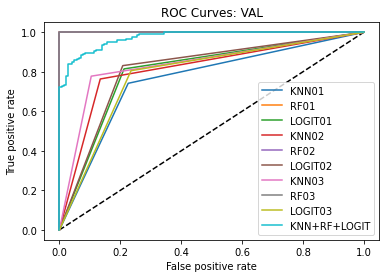

In [49]:
#ROC curves resulting from applying the models and their ensemble to the same patient profiles that we used for training:
output[1]

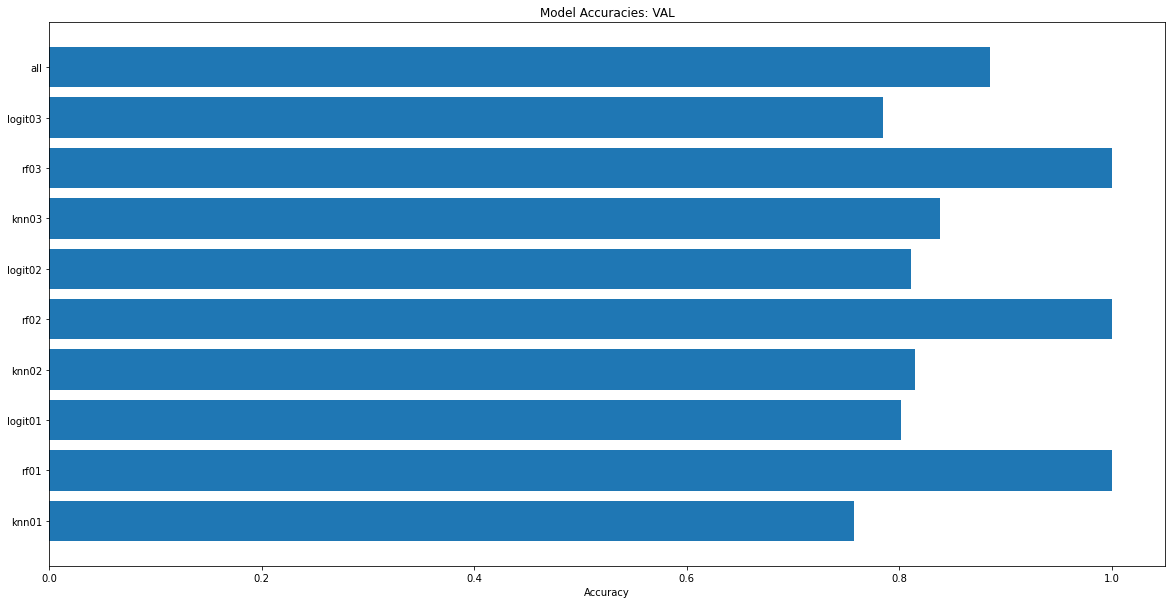

In [50]:
#Accuracies of the models and their ensemble when applying them to the same patient profiles that we used for training:
output[2]

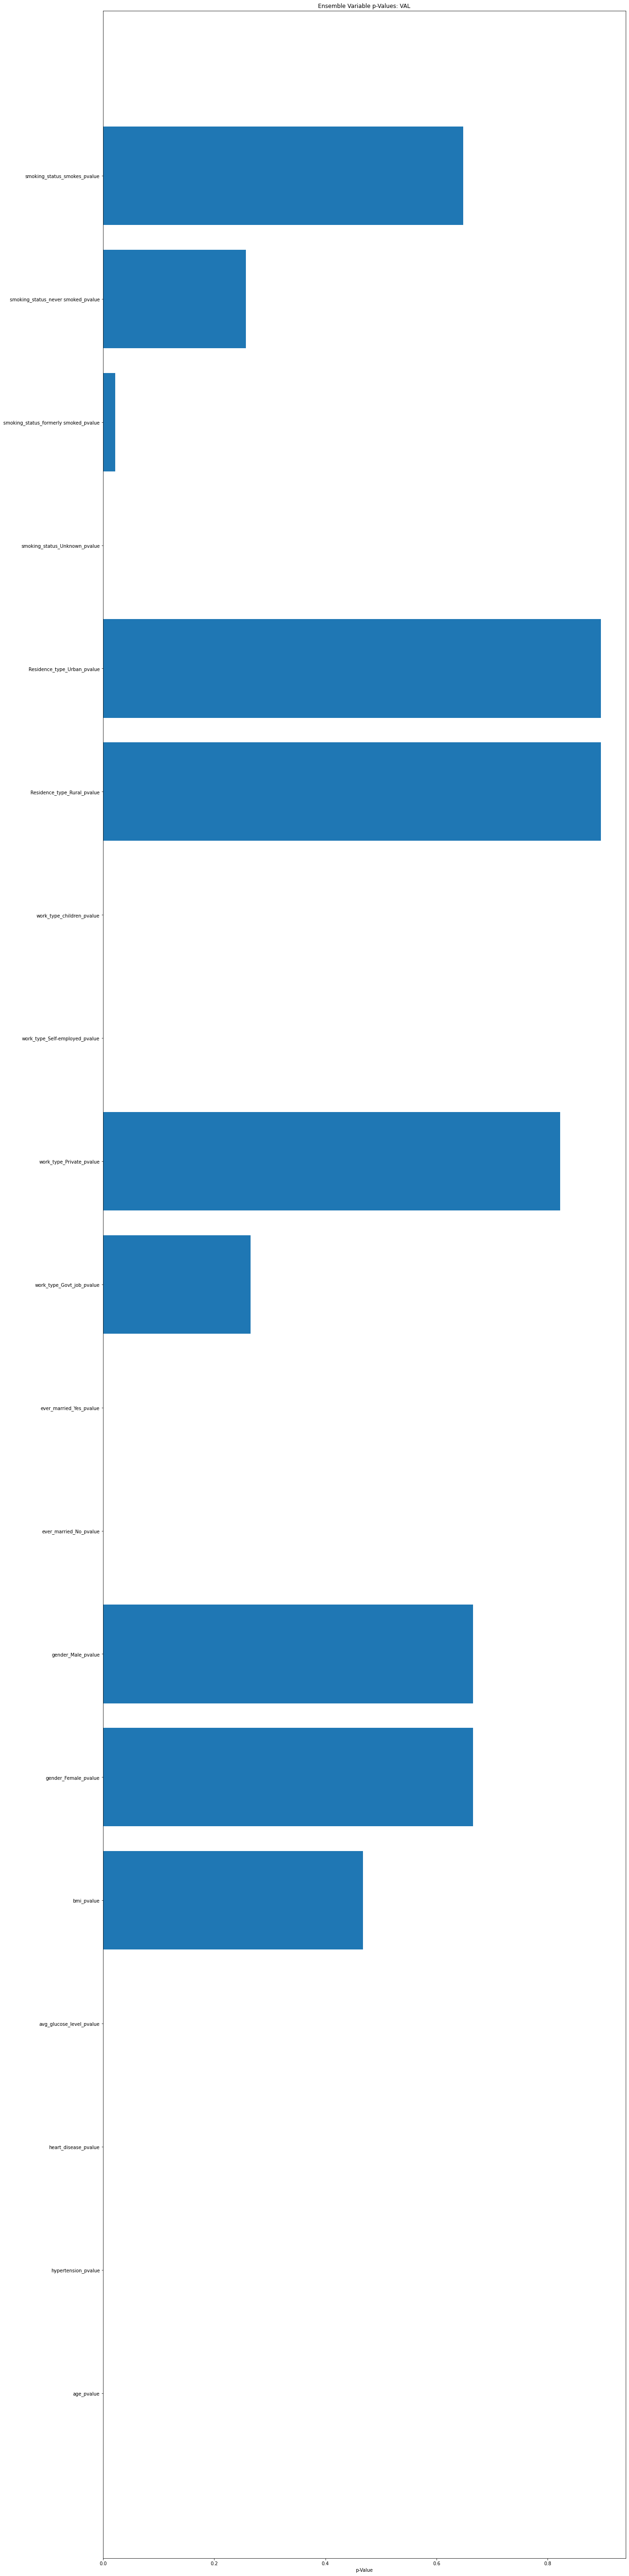

In [51]:
#p-Values of the variables (categoricals encoded) of the ensemble if applied to the patient profiles that we used for training:
output[3]

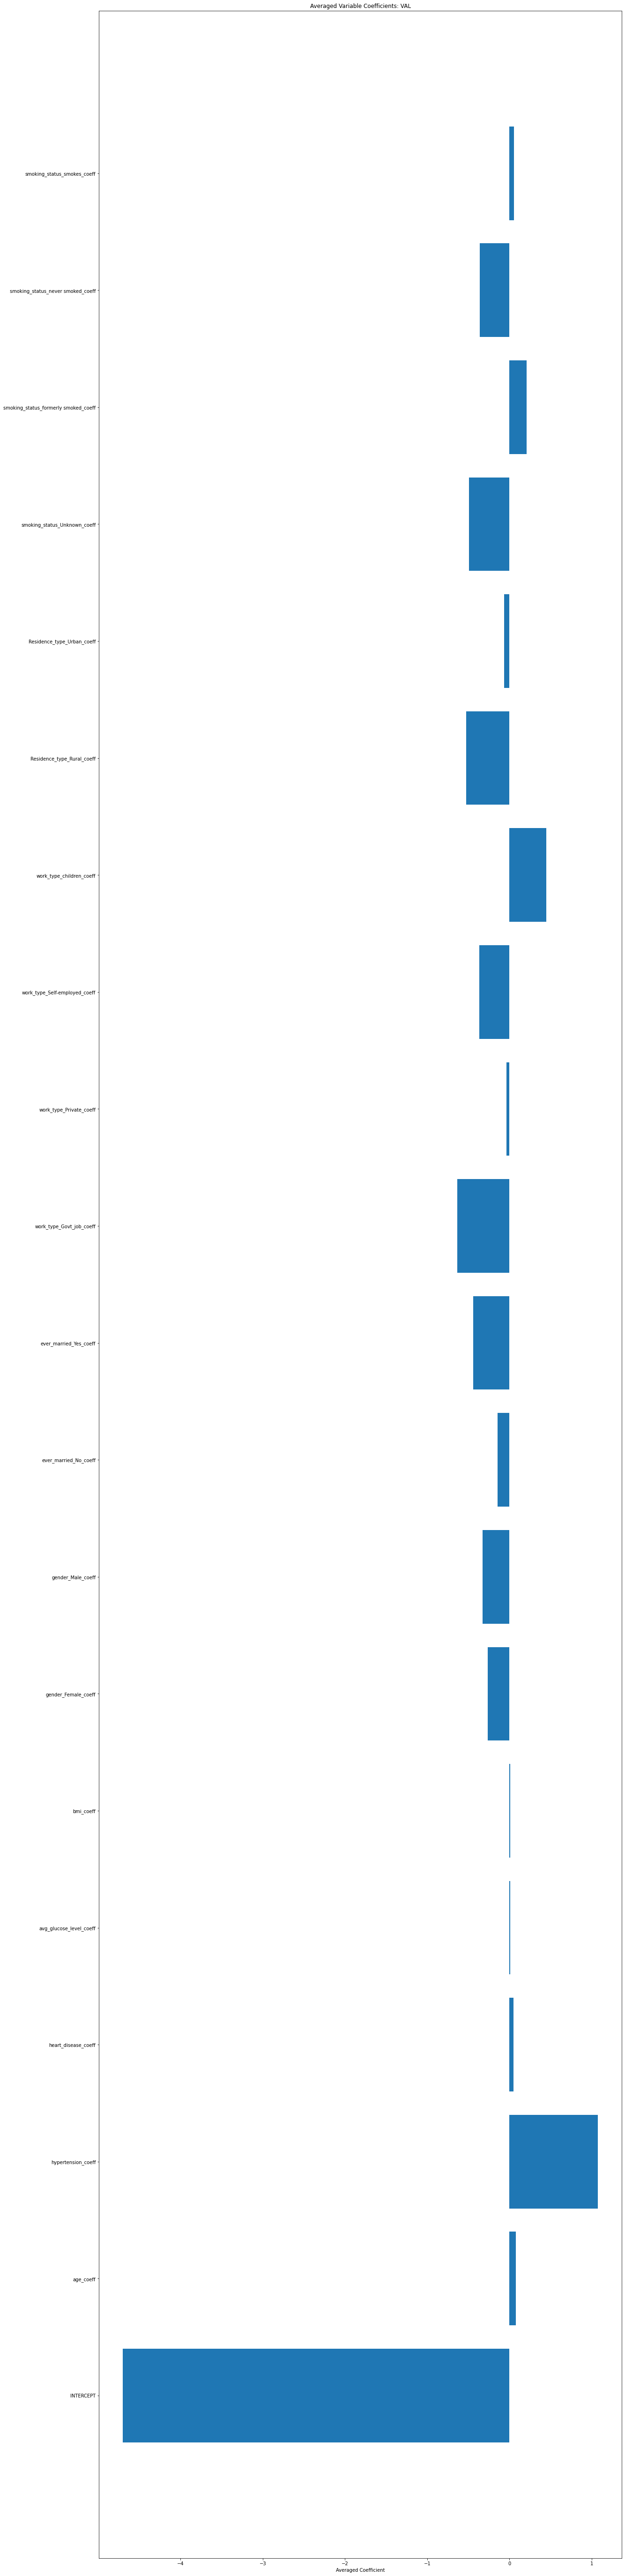

In [52]:
#Averaged coefficients of the variables (categoricals encoded) of the logistical regression models comprising the ensemble
#when applied to the patient profiles that we used for training:
output[4]

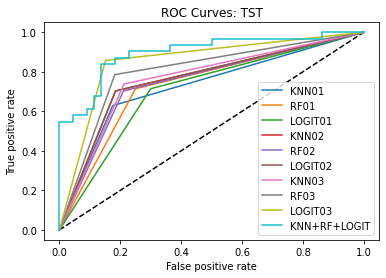

In [53]:
#ROC curves resulting from applying the models and their ensemble to the patient profiles split off the training profiles:
output[5]

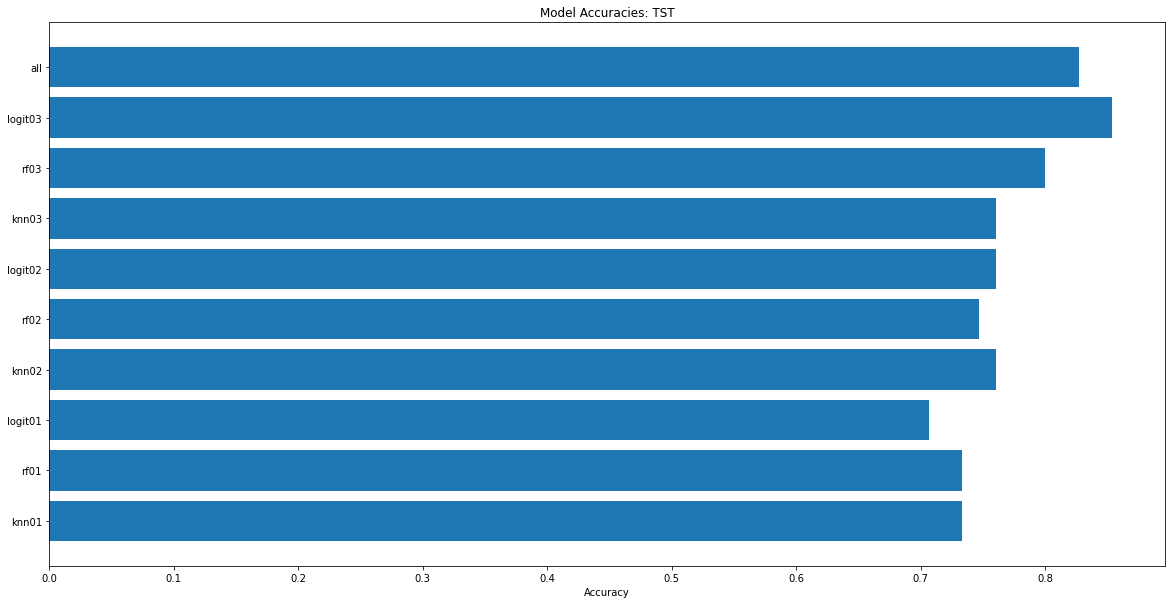

In [54]:
#Accuracies of the models and their ensemble when applying them to the patient profiles split off the training profiles:
output[6]

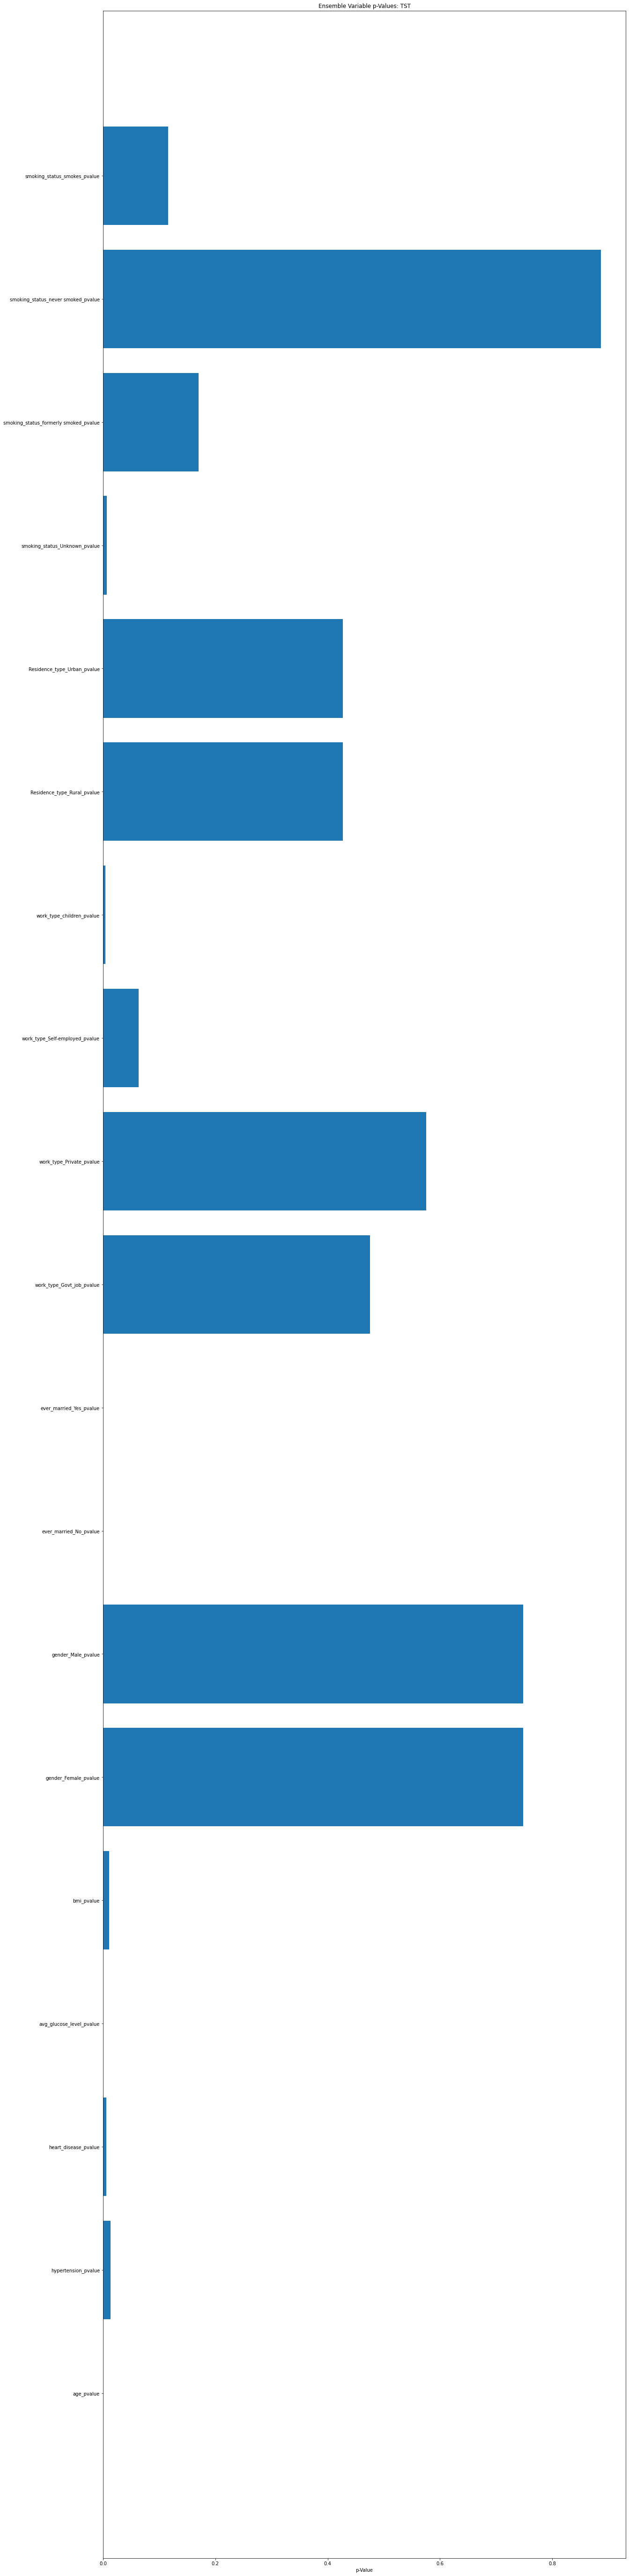

In [55]:
#p-Values of the variables (categoricals encoded) of the ensemble if applied to the patient profiles split off the training
#profiles:
output[7]

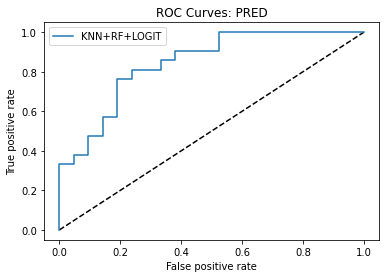

In [56]:
#ROC curve resulting from applying the ensemble to the patient profiles explicitly separated for prediction (DataframeC):
output[8]

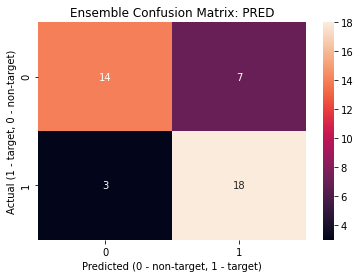

In [57]:
#Confusion matrix resulting from applying the ensemble to the patient profiles explicitly separated for prediction (DataframeC):
output[9]

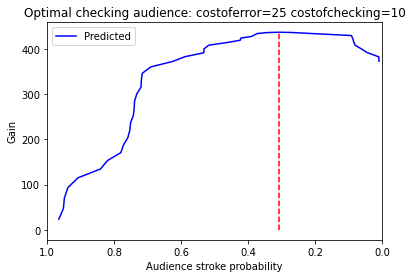

In [58]:
#Expected gain/loss chart (x-axis represents stroke probability) resulting from applying the ensemble to the patient profiles 
#explicitly separated for prediction (DataframeC):
output[10]

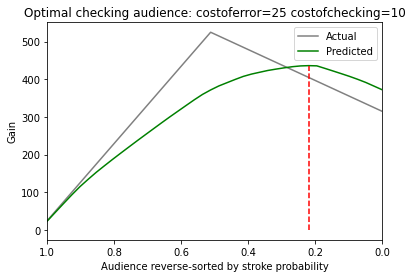

In [59]:
#Expected gain/loss chart (x-axis represents the patient audience reverse-sorted by stroke probability) resulting from applying
#the ensemble to the patient profiles explicitly separated for prediction (DataframeC):
output[11]

In [60]:
#Simulate accuracy:

Simulation=pd.DataFrame(columns=['TP','FN','TN','FP','ACC','TPR','TNR','PPV','NPV'])

for s in range(1,11):
    Confusion=run(Data, droplist, balancing, training, preddraw, costoferror, costofchecking, predfrac, testdraws, folds, bagfrac, weights, weightsaccval, weightsacctst, path)
    Simulation=Simulation.append(Confusion[0])
    print(s," out of 10 simulation runs completed.")

1  out of 10 simulation runs completed.
2  out of 10 simulation runs completed.
3  out of 10 simulation runs completed.
4  out of 10 simulation runs completed.
5  out of 10 simulation runs completed.
6  out of 10 simulation runs completed.
7  out of 10 simulation runs completed.
8  out of 10 simulation runs completed.
9  out of 10 simulation runs completed.
10  out of 10 simulation runs completed.


In [61]:
#Visualize accuracy simulation results:

Simulation=Simulation.reset_index(drop=True)
Simulation=Simulation.reset_index(drop=False)

f=plt.figure()
plt.plot(Simulation['index']+1,Simulation['ACC'],label='ACC')
plt.plot(Simulation['index']+1,Simulation['TPR'],label='TPR')
plt.plot(Simulation['index']+1,Simulation['TNR'],label='TNR')
plt.plot(Simulation['index']+1,Simulation['PPV'],label='PPV')
plt.plot(Simulation['index']+1,Simulation['NPV'],label='NPV')
plt.ylim(0,1)
plt.xlabel('Simulation run')
plt.ylabel('Indicator')
plt.title('Quality Check: SIM')
plt.legend(loc='best')
f.savefig(path+'\DSTI091.png')
f091=f
plt.close(f)

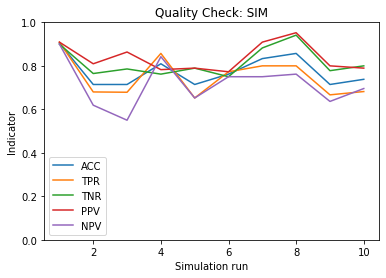

In [62]:
f091